# Geometric Brownian Motion Demo

Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

modification date: 08/03/2024


In [22]:
import qmcpy as qp
import numpy as np
import scipy.stats as sc
import pandas as pd
import time
from matplotlib import pyplot
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display




Geometric Brownian motion  is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. $[1]$

Mathematically, it can be defined as follows:

$\large{S_t = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W_t}}$, 

where
* $S_0$ is the initial value, 
* $\mu$ is a drift coefficient
* $\sigma$ difussion coefficient  
* $W_t$ is a (standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

## GMB object

Geometric Brownian Motion in QMCPy inherits from Gaussian True Measure Class. $[2]$, $[3]$

In [2]:
help(qp.GeometricBrownianMotion.__init__)

Help on function __init__ in module qmcpy.true_measure.geometric_brownian_motion:

__init__(self, sampler, t_final=1, initial_value=1, drift=0, diffusion=1, decomp_type='PCA')
    GeometricBrownianMotion(t) = initial_value * exp[(drift - 0.5 * diffusion^2) * t
                                                     + diffusion * StandardBrownianMotion(t)]
    
    Args:
        sampler (DiscreteDistribution/TrueMeasure): A
            discrete distribution from which to transform samples or a
            true measure by which to compose a transform
        t_final (float): end time for the geometric Brownian motion, non-negative
        initial_value (float): positive initial value of the process
        drift (float): drift coefficient
        diffusion (float): diffusion coefficient (also known as volatility), positive
        decomp_type (str): method of decomposition either
            "PCA" for principal component analysis or
            "Cholesky" for Cholesky decomposition.



In [3]:
help(qp.GeometricBrownianMotion.gen_samples)

Help on function gen_samples in module qmcpy.true_measure._true_measure:

gen_samples(self, *args, **kwargs)
    Generate samples from the discrete distribution
    and transform them via the transform method. 
    
    Args:
        args (tuple): positional arguments to the discrete distributions gen_samples method
        kwargs (dict): keyword arguments to the discrete distributions gen_samples method
    
    Returns: 
        ndarray: n x d matrix of transformed samples



In [4]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2)) 
gbm

GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean            [-0.25 -0.5 ]
    covariance      [[0.5 0.5]
                    [0.5 1. ]]
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                    [0.649 1.718]]
    decomp_type     PCA

In [5]:
gbm.gen_samples(n=4) # generates four 2-dimensional samples

array([[1.25601441, 0.30759542],
       [1.55734278, 2.02465369],
       [0.71306179, 1.02895202],
       [0.49631322, 0.18484151]])

## GMB vs Brownian motion

Below we compare Brownian motion and geometric Brownian motion using the same parameters: `drift` = 0, `diffusion` = 1, `initial_value` = 1

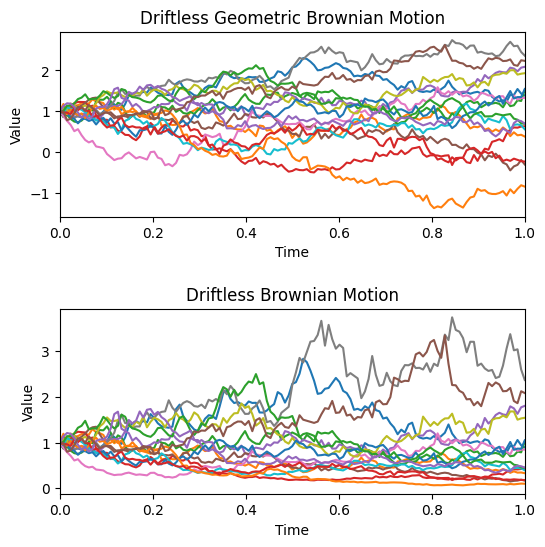

In [6]:
n = 16
discrete_distrib = qp.Lattice(2**7)
geometric_brownian_motions = {
     'Driftless Geometric Brownian Motion': qp.BrownianMotion(discrete_distrib,initial_value=1),
     'Driftless Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib)}
fig,ax = pyplot.subplots(nrows=len(geometric_brownian_motions),
                          ncols=1,figsize=(6,3*len(geometric_brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,gbm) in enumerate(geometric_brownian_motions.items()):
     t = gbm.gen_samples(n)
     t_w_init = np.hstack([gbm.initial_value*np.ones((n,1)),t])
     tvec_w_0 = np.hstack([0,gbm.time_vec])
     ax[i].plot(tvec_w_0,t_w_init.T)
     ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
     ax[i].set_title(name)
     ax[i].set_xlabel('Time')  
     ax[i].set_ylabel('Value') 
plt.subplots_adjust(hspace=0.5)
plt.show();


## Generating and plotting GBM paths

In [7]:
def plot_gbm_paths(sampler, t_final, initial_value, drift, diffusion, n):
    
    gbm = qp.GeometricBrownianMotion(sampler, t_final, initial_value, drift, diffusion)
    t = gbm.gen_samples(n)
    
    initial_values = np.full((n, 1), gbm.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], gbm.time_vec))

    plt.figure(figsize=(7, 4))
    plt.plot(tvec_w_0, t_w_init.T) 
    plt.title(f'Realizations of Geometric Brownian Motion using {type(sampler).__name__} points')
    plt.xlabel('t')
    plt.ylabel('S(t)')
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]])
    plt.show()

## GBM using Standard Uniform Distribution 

Now, using `plot_gbm_paths`, we generate 32 GBM paths to model stock price, $S(t)$, with initial value $S_0$ = 50, drift coeffient, $\mu = 0.1$, diffusion coefficient $\sigma = 0.2$ using IID points

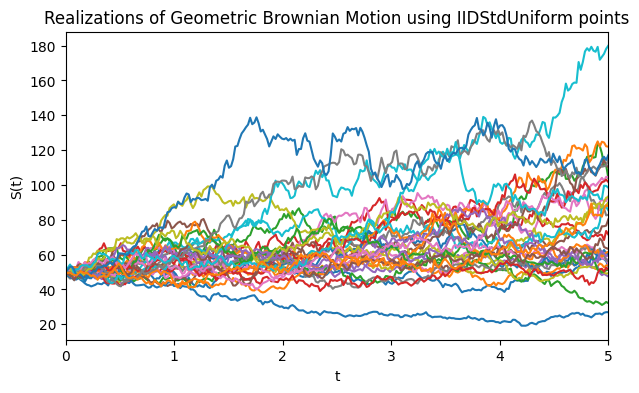

In [8]:
gbm_iid = plot_gbm_paths(qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

## GBM using low-discrepancy Lattice sequence distrubtion 

Using the same parameter values as in example above, we generate 32 GBM paths to model stock price using low-discrepancy lattice points

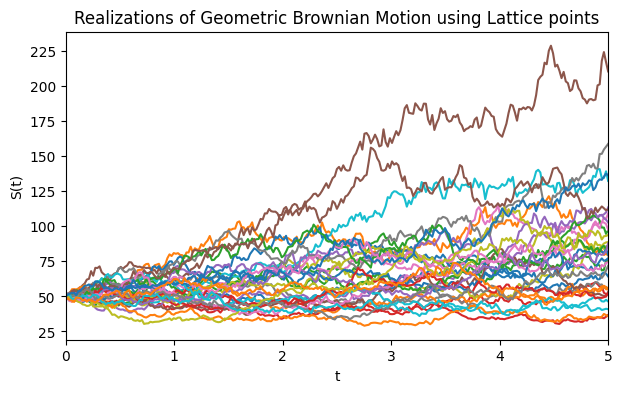

In [9]:
gbm_lattice = plot_gbm_paths(qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

In [10]:

def plot_gbm_paths_with_distribution(N, sampler, t_final, initial_value, drift, diffusion,n):

    gbm = qp.GeometricBrownianMotion(sampler, t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion)
    gbm_path = gbm.gen_samples(2**n)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    T = max(gbm.time_vec)
    
    # Plot GBM paths
    ax.plot(gbm.time_vec, gbm_path.T, lw=0.75, alpha=0.7, color='skyblue')
    
    # Set up main plot
    ax.set_title(f'Geometric Brownian Motion Paths\n{N} Simulations, T = {T}, $\mu$ = {drift:.1f}, $\sigma$ = {diffusion:.1f}, using {type(sampler).__name__} points')
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$S(t)$')
    ax.set_ylim(bottom=0)
    ax.set_xlim(0, T)
    
    # Add histogram
    final_values = gbm_path[:, -1]
    hist_ax = ax.inset_axes([1.05, 0., 0.5, 1])
    hist_ax.hist(final_values, bins=10, density=True, alpha=0.5, 
                 color='skyblue', orientation='horizontal')
    
    # Add theoretical lognormal PDF
    shape, _, scale = sc.lognorm.fit(final_values, floc=0)
    x = np.linspace(0, max(final_values), 1000)
    pdf = sc.lognorm.pdf(x, shape, loc=0, scale=scale)
    hist_ax.plot(pdf, x, 'r-', lw=2, label='Lognormal PDF')
    
    # Finalize histogram
    hist_ax.set_title(f'E[$S_T$] = {np.mean(final_values):.2f}', pad=20)
    hist_ax.axhline(np.mean(final_values), color='blue', linestyle='--', lw=1.5, label=r'$E[S_T]$')
    hist_ax.set_yticks([])
    hist_ax.set_xlabel('Density')
    hist_ax.legend()
    hist_ax.set_ylim(bottom=0)
    
    plt.tight_layout()  
    plt.show()

## Interactive Visualization

The following code defines a set of sliders to control parameters for simulating paths of GBM. It sets the machine epsilon (eps) as the minimum value for `initial_value`,  `t_final`, and `diffusion`, ensuring they are always positive.  The function `plot_gbm_paths_with_distribution` then visualizes the GBM paths based on the specified parameters in the left subplot and fits a lognormal distribution to the histogram of the data values at the final time point in the right subplot.

In [1]:

eps = np.finfo(float).eps
slider_style = {'handle_color': 'blue'}

@widgets.interact
def f(n=widgets.IntSlider(min=0, max=8, step=1, value=10, style=slider_style),
      t_final=widgets.FloatSlider(min=eps, max=10, step=0.1, value=10, style=slider_style),
      initial_value=widgets.FloatSlider(min=eps, max=100, step=0.1, value=40, style=slider_style),
      drift=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.1, style=slider_style),
      diffusion=widgets.FloatSlider(min=eps, max=4, step=0.1, value=0.2, style=slider_style),
      sampler=widgets.Dropdown(options=['IIDStdUniform', 'Lattice','Halton','Sobol'], value='IIDStdUniform', description='Sampler')
):
    if sampler == 'IIDStdUniform':
       sampler_instance = qp.IIDStdUniform(2**n, seed=7)

    elif sampler == 'Lattice':
         sampler_instance = qp.Lattice(2**n, seed=7)

    elif sampler == 'Halton':
         sampler_instance = qp.Halton(2**n, seed=7)
         
    elif sampler == 'Sobol':
          sampler_instance = qp.Sobol(2**n, seed=7)
     
    plot_gbm_paths_with_distribution(2**n,sampler_instance ,t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion, n=n)



SyntaxError: invalid syntax (2593081858.py, line 1)

References:

* $[1]$ Sheldon. Ross. (2014) *Introduction to Probability Models*. Academic Press, 11th edition
* $[2]$ Choi, Sou-Cheng T.
and Hickernell, Fred J.
and Jagadeeswaran, Rathinavel
and McCourt, Michael J.
and Sorokin, Aleksei G. (2022) Quasi-Monte Carlo Software, In Alexander Keller, editor, *Monte Carlo and Quasi-Monte Carlo Methods* Springer International Publishing
* $[3]$ S.-C. T. Choi and F. J. Hickernell and R. Jagadeeswaran and M. McCourt and A. Sorokin. (2023) QMCPy: A quasi-Monte Carlo Python Library (versions 1--1.4)

In [23]:
# to do:

# look into non-finance examples

# figure out how to render widgets 